## ATLAS Open Data Initialisation

### To setup everytime
We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* awkward: lets us handle complex and nested data structures efficiently
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* lmfit: tool for statistical fitting

In [1]:
import sys
import uproot # for reading .root files
import time # to measure time to analyse
import math # for mathematical functions such as square root
import awkward as ak # for handling complex and nested data structures efficiently
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
import lmfit # for the signal and background fits
import vector #to use vectors

import pyhf, json, cabinetry #likelihood model

## Example 1: Reading data

We will use the [atlasopenmagic](https://opendata.atlas.cern/docs/data/atlasopenmagic) to access the open data directly from the ATLAS OpenData Portal so no need to download any samples. First we import the module and load the Open Data release.

In [2]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Available releases:
2016e-8tev           2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev          2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp             2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi             2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta     2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen-13tev    2025 Open Data for research release for event generation at 13 TeV (https://opendata.cern.ch/record/160000).
2025r-evgen-13p6tev  2025 Open Data for research release for event generation at 13.6 TeV (https://opendata.cern.ch/record/160000).
Fetching and caching all metadata for release: 2025e-13tev-beta...
F

In [3]:
# Select the skim to use for the analysis
skim = "GamGam"

# Let's get the list of files to go through
# Notice that we use "cache" so that the files are downloaded locally and not streamed
files_list = atom.get_urls('data', skim, protocol='https', cache=True)

In [4]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==True) & (photon_isTightID[:,1]==True)

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] > 50) & (photon_pt[:,1] > 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[:,0]/photon_pt[:,0]) < 0.055) & ((photon_ptcone20[:,1]/photon_pt[:,1]) < 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) | (np.abs(photon_eta[:, 0]) > 1.37)
    condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) | (np.abs(photon_eta[:, 1]) > 1.37)
    return condition_0 & condition_1

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass != 0)

# Cut on the pT relative to the invariant mass
# Only the events where the invididual photon pT is larger than 35% of the invariant mass are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[:,0]/invariant_mass) > 0.35) & ((photon_pt[:,1]/invariant_mass) > 0.35)

## Final Analysis

For the final analysis, we'll begin by applying the cuts and calculating the invariant masses across all the data. Once that's done, we'll fit the data to uncover the Higgs boson peak. Let's kick things off by applying the cuts and calculating those invariant masses!

In [5]:
# Controls the fraction of all the events analysed. All of the data is used by
# default to run this analysis (implemented in the loop over the tree). Reduce
# this if you want the code to run quicker. This can take several minutes to
# process the entire dataset
fraction = 1.0
# Holder for the masses as we process the files
sample_data = []
variables = ["photon_pt","photon_eta","photon_phi","photon_e","photon_isTightID","photon_ptcone20"]

# Loop over all the files in our list
for afile in files_list:

    # Print which sample is being processed
    print(f'Processing file {afile} ({files_list.index(afile)}/{len(files_list)})')

    # Open file
    tree = uproot.open(afile + ":analysis")

    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree and calculate the invariant mass
    for data in tree.iterate(variables, library="ak", entry_stop=int(numevents*fraction)):

        photon_isTightID = data['photon_isTightID']
        data = data[cut_photon_reconstruction(photon_isTightID)]

        photon_pt = data['photon_pt']
        data = data[cut_photon_pt(photon_pt)]

        data = data[cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

        photon_eta = data['photon_eta']
        data = data[cut_photon_eta_transition(photon_eta)]

        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        data = data[cut_mass(data['mass'])]

        data = data[cut_iso_mass(data['photon_pt'], data['mass'])]

        # Append data to the whole sample data list
        sample_data.append(data['mass'])
        
# turns sample_data back into an awkward array
all_data = ak.concatenate(sample_data)

Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root (0/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root (1/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root (2/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root (3/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root (4/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodJ.GamGam.root (5/16)
Processing file simplecache::https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data16_periodA.GamG

We are now ready to fit our data to effectively detect the Higgs boson! We will use a combination of a 4th order polynomial and a Gaussian function. The polynomial function represents the background, while the Gaussian function represents our signal. The Gaussian model is used to fit the signal due to the nature of the detector's resolution. The fourth-order polynomial is chosen for the background because it offers enough flexibility to capture the overall shape without overfitting, thereby reducing the influence of spurious data—random, irrelevant fluctuations or noise that do not correspond to the true signal or background.

## Estimating a background

In [6]:
def fitModel(bin_centres, data_x, mass=125, degree=3):
    
    # data fit
    polynomial_mod = lmfit.models.PolynomialModel( degree ) # 4th order polynomial
    gaussian_mod = lmfit.models.GaussianModel() # Gaussian

    # set initial guesses for the parameters of the polynomial model
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres)
    #for par in pars: pars[par].set(value=1)

    # set initial guesses and ranges for the parameters of the Gaussian model
    pars += gaussian_mod.make_params(center=dict(value=mass, vary=False),
                       amplitude=dict(value=100, min=0, max=1e3),
                       sigma=dict(value=2, min=1, max=5))

    model = polynomial_mod + gaussian_mod # combined model

    # fit the model to the data
    result = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors ) 
    print(result.fit_report())

    # background part of fit
    params_dict = result.params # get the parameters from the fit to data
    #for par in params_dict: print(f"{par},\t{params_dict[par].value},\t{params_dict[par].stderr}")
    background_x=polynomial_mod.eval(params=params_dict,x=bin_centres)

    # data fit - background fit = signal fit
    signal_x = gaussian_mod.eval(params=params_dict,x=bin_centres)

    # best fit result in total
    #sb_x=result.best_fit
    
    # model uncertainity
    # dely0 = result.eval_uncertainty(sigma=1,params=params_dict)
    # print(dely0)
    # from copy import deepcopy
    # params_dict_bkg=deepcopy(params_dict)
    # #for par in params_dict.keys():
    # #    if par=="amplitude" or par=="center" or par=="sigma":
    # #        params_dict_bkg.set(vary=False)
    # #        print(par)
    # for name in params_dict_bkg: params_dict_bkg[name].vary = (name not in ["amplitude", "center", "sigma","fwhm","height"])   
    # for name in params_dict_bkg:
    #     print(name,params_dict_bkg[name],params_dict_bkg[name].vary)
    # print(params_dict_bkg)
    # dely = result.eval_uncertainty(sigma=1,params=params_dict_bkg)
    # print(dely-dely0)

    model_x_errors = result.eval_uncertainty(sigma=1)
    
    return signal_x, background_x, model_x_errors, result

In [7]:
def plotAnalysis(bin_centres, data_x, data_x_errors, background_x, signal_x, model_x_errors):
    # *************
    # Main plot
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
    main_axes = plt.gca() # get current axes

    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, fmt='ko', label='Data', markersize=4) # black circles

    # plot the background only fit
    main_axes.plot(bin_centres, background_x, '--b', label='Bkg (4th order polynomial)') # dashed blue line

    plt.fill_between(bin_centres, background_x-model_x_errors, background_x+model_x_errors, color="gray", label=r'1-$\sigma$ uncertainty band')

    # plot the signal + background fit
    main_axes.plot(bin_centres, signal_x+background_x,'-r', label='Sig+Bkg Fit ($m_H=125$ GeV)') # single red line

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        labelbottom=False, # don't draw tick labels on bottom axis
                        right=True ) # draw ticks on right axis

    # write y-axis label for main
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        horizontalalignment='right')

    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5 )

    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, 0.92, 'ATLAS Open Data', transform=main_axes.transAxes, fontsize=13 )

    # Add text 'for education' on plot
    plt.text(0.2, 0.86, 'for education', transform=main_axes.transAxes, style='italic',fontsize=8 )

    lumi = 36.1
    lumi_used = str(lumi*fraction) 
    plt.text(0.2, 0.8, r'$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', transform=main_axes.transAxes ) 

    # Add a label for the analysis carried out
    plt.text(0.2, 0.74, r'$H \rightarrow \gamma\gamma$', transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                    loc='lower left' ) # legend location

    # *************
    # Data-Bkg plot
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', symmetric=True) )

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=data_x-background_x, yerr=data_x_errors, fmt='ko',markersize=4 ) # black circles

    # draw the background only fit
    sub_axes.plot(bin_centres, background_x-background_x, '--b' )  # dashed blue line

    # draw the fit to data
    sub_axes.plot(bin_centres, signal_x, '-r' ) # single red line

    plt.fill_between(bin_centres, -model_x_errors, model_x_errors, color="gray", label=r'1-$\sigma$ uncertainty band')

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )

    # x-axis label
    sub_axes.set_xlabel(r'Di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]', x=1, horizontalalignment='right',fontsize=13 )

    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', direction='in', top=True, right=True ) 

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

In [8]:
#Bin edges
xmin = 100 #GeV
xmax = 160 #GeV
step_size = 1 #GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

#Set the data
partial_data =all_data[::1]
data_x,_ = np.histogram(ak.to_numpy(partial_data), bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data

[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 60
    # variables        = 6
    chi-square         = 55.3594588
    reduced chi-square = 1.02517516
    Akaike info crit   = 7.17017842
    Bayesian info crit = 19.7362458
    R-squared          = 0.99880517
[[Variables]]
    c0:         17748.0823 +/- 4673.17574 (26.33%) (init = 8269.506)
    c1:         34.1652966 +/- 107.789442 (315.49%) (init = 251.4802)
    c2:        -2.13134456 +/- 0.82051792 (38.50%) (init = -3.768142)
    c3:         0.00805976 +/- 0.00206315 (25.60%) (init = 0.01211949)
    amplitude:  764.579417 +/- 192.539613 (25.18%) (init = 100)
    center:     125 (fixed)
    sigma:      1.10368968 +/- 0.29158152 (26.42%) (init = 2)
    fwhm:       2.59899054 +/- 0.68662198 (26.42%) == '2.3548200*sigma'
    height:     276.366695 +/- 61.8652230 (22.39%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (u

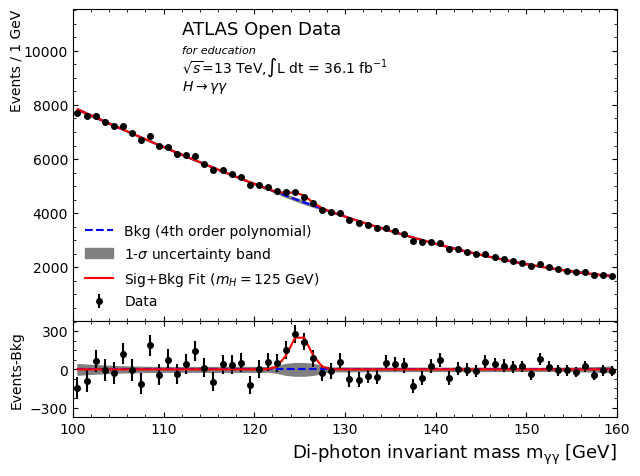

In [9]:
signal_x, background_x, model_x_errors,_=fitModel(bin_centres, data_x)
plotAnalysis(bin_centres, data_x, data_x_errors, background_x, signal_x, model_x_errors)

[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12000
    # data points      = 60
    # variables        = 5
    chi-square         = 70.8363360
    reduced chi-square = 1.28793338
    Akaike info crit   = 19.9616516
    Bayesian info crit = 30.4333744
    R-squared          = 0.99829522
##  Warning: uncertainties could not be estimated:
    amplitude:  at boundary
[[Variables]]
    c0:         35933.0784 (init = 34045.79)
    c1:        -386.455822 (init = -356.4378)
    c2:         1.07458111 (init = 0.9584601)
    amplitude:  999.999079 (init = 100)
    center:     125 (fixed)
    sigma:      1.34278336 (init = 2)
    fwhm:       3.16201311 == '2.3548200*sigma'
    height:     297.100743 == '0.3989423*amplitude/max(1e-15, sigma)'
[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 60
    # variables 

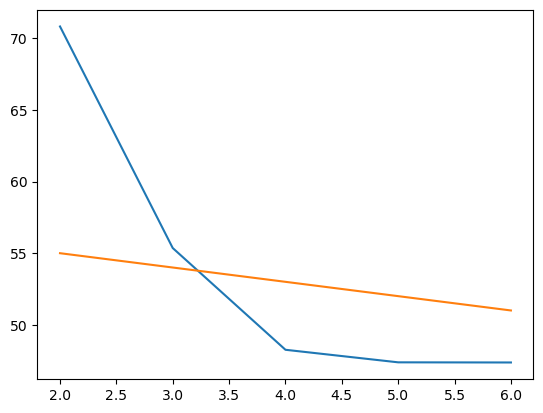

In [10]:
degrees=range(2,7)
chi2s=[]
dofs=[]

for degree in degrees:
    signal_x, background_x, model_x_errors, result=fitModel(bin_centres, data_x, degree=degree)
    chi2s.append(result.chisqr)
    dofs.append(result.nfree)

plt.plot(degrees,chi2s)
plt.plot(degrees,dofs)

## Make a likelihood mode

In [11]:
def makePyhfConfig(data_x,signal_x,background_x,model_x_errors):
    model_spec = {
        "channels": [
            {
                "name": "channel",
                "samples": [
                    {
                        "name": "signal",
                        "data": signal_x.tolist(),
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data":None}  # parameter of interest
                        ]
                    },
                    {
                        "name": "background",
                        "data": background_x.tolist(),
                        "modifiers": [
                            {"name": "bkg_uncert", "type": "shapesys", "data": model_x_errors.tolist()}
                        ]
                    }
                ]
            }
        ]
    }
    # Build the model
    # model = pyhf.Model(model_spec)
    ## data = np.concatenate([data_x, model.config.auxdata])
    # data = data_x.tolist()+model.config.auxdata

    #The observed data must be given as a named observation in the channel
    workspace_spec = {
        "version": "1.0.0",
        "channels": model_spec["channels"],
        "observations": [
            {"name": "channel", "data": data_x.tolist()}
        ],
        "measurements": [
            {
                "name": "measurement",
                "config": {
                    "poi": "mu",
                    "parameters": []
                }
            }
        ]
    }
    return workspace_spec

In [12]:
workspace_spec=makePyhfConfig(data_x,signal_x,background_x,model_x_errors)

# Create the workspace object
ws = pyhf.Workspace(workspace_spec)
model = ws.model()       # same as before, created from workspace
data = ws.data(model)   # observed data + auxdata automatically assembled

print(f"  POI name:   {model.config.poi_name}")
print(f"  channels:   {model.config.channels}")
print(f"     nbins:   {model.config.channel_nbins}")
print(f"   samples:   {model.config.samples}")
print(f" modifiers:   {model.config.modifiers}")
print(f"N paramaters: {model.config.npars}")
print(f"parameters:   {model.config.parameters}")
print(f"  nauxdata:   {model.config.nauxdata}")
#print(f"   auxdata:   {model.config.auxdata}")

  POI name:   mu
  channels:   ['channel']
     nbins:   {'channel': 60}
   samples:   ['background', 'signal']
 modifiers:   [('bkg_uncert', 'shapesys'), ('mu', 'normfactor')]
N paramaters: 61
parameters:   ['bkg_uncert', 'mu']
  nauxdata:   60


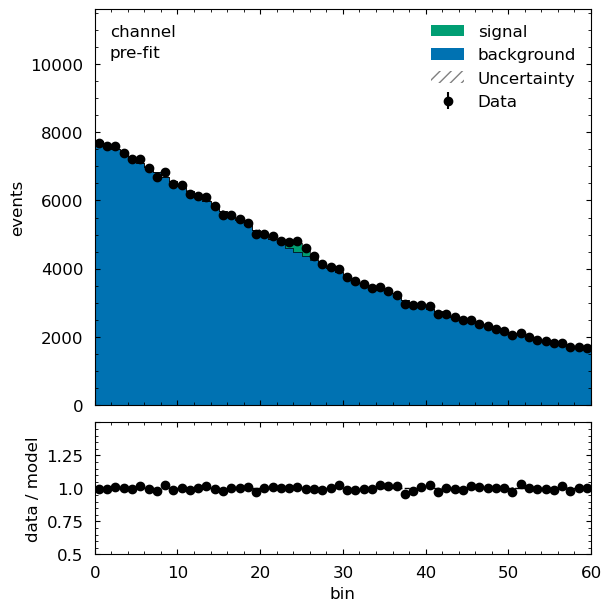

In [13]:
model_prefit = cabinetry.model_utils.prediction(model)
_ = cabinetry.tabulate.yields(model_prefit, data)
_ = cabinetry.visualize.data_mc(model_prefit, data)

In [14]:
bestfit = pyhf.infer.mle.fit(data, model)
mu_hat = bestfit[model.config.poi_index]
print("Best-fit μ:", mu_hat)

Best-fit μ: 1.002315588166286


In [15]:
CLs = pyhf.infer.hypotest(1.0, data, model, test_stat="qtilde")
print("CLs:", CLs)

CLs: 0.5000000078563956


In [16]:
significance_results = cabinetry.fit.significance(model, data)
print(significance_results.observed_significance)

5.558968091290304


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4335971
    reduced chi-square = 1.52654809
    Akaike info crit   = 31.0589114
    Bayesian info crit = 43.6249788
    R-squared          = 0.99828394
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8233.79630 (init = 8269.506)
    c1:         251.690288 (init = 251.4802)
    c2:        -3.76551134 (init = -3.768142)
    c3:         0.01210300 (init = 0.01211949)
    amplitude:  6.4693e-05 (init = 100)
    center:     140 (fixed)
    sigma:      4.18897228 (init = 2)
    fwhm:       9.86427570 == '2.3548200*sigma'
    height:     6.1611e-06 == '0.3989423*amplitude/max(1e-15, sigma)'


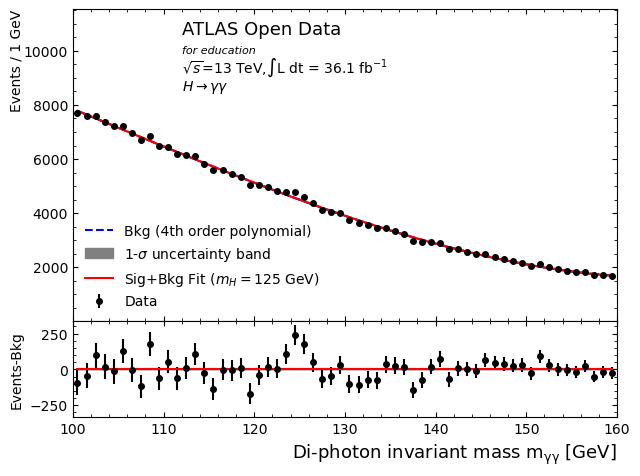

In [17]:
signal_x, background_x, model_x_errors,_ =fitModel(bin_centres, data_x, mass=140)
plotAnalysis(bin_centres, data_x, data_x_errors, background_x, signal_x, model_x_errors)

In [18]:
masses=np.linspace(110,140,25)
sigs=[]
for mass in masses:
    signal_x, background_x, model_x_errors,_=fitModel(bin_centres, data_x, mass=mass)
    workspace_spec=makePyhfConfig(data_x,signal_x,background_x,model_x_errors)

    # Create the workspace object
    ws = pyhf.Workspace(workspace_spec)
    model = ws.model()       # same as before, created from workspace
    data = ws.data(model)   # observed data + auxdata automatically assembled
    
    significance_results = cabinetry.fit.significance(model, data)
    print(significance_results.observed_significance)
    sigs.append(significance_results.observed_significance)

[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 60
    # variables        = 6
    chi-square         = 81.5252622
    reduced chi-square = 1.50972708
    Akaike info crit   = 30.3941025
    Bayesian info crit = 42.9601699
    R-squared          = 0.99828256
[[Variables]]
    c0:         11786.9094 +/- 5367.28428 (45.54%) (init = 8269.506)
    c1:         167.783910 +/- 124.536166 (74.22%) (init = 251.4802)
    c2:        -3.11479605 +/- 0.95455863 (30.65%) (init = -3.768142)
    c3:         0.01044297 +/- 0.00241718 (23.15%) (init = 0.01211949)
    amplitude:  219.350232 +/- 720.887009 (328.65%) (init = 100)
    center:     110 (fixed)
    sigma:      3.10929462 +/- 8.53098411 (274.37%) (init = 2)
    fwhm:       7.32182916 +/- 20.0889320 (274.37%) == '2.3548200*sigma'
    height:     28.1440315 +/- 58.4465062 (207.67%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


0.0
[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4422164
    reduced chi-square = 1.52670771
    Akaike info crit   = 31.0651847
    Bayesian info crit = 43.6312521
    R-squared          = 0.99828435
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8250.62544 (init = 8269.506)
    c1:         251.598597 (init = 251.4802)
    c2:        -3.76701575 (init = -3.768142)
    c3:         0.01211210 (init = 0.01211949)
    amplitude:  2.1772e-04 (init = 100)
    center:     116.25 (fixed)
    sigma:      2.44149993 (init = 2)
    fwhm:       5.74929287 == '2.3548200*sigma'
    height:     3.5576e-05 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
3.814697265626872e-

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4392539
    reduced chi-square = 1.52665285
    Akaike info crit   = 31.0630286
    Bayesian info crit = 43.6290960
    R-squared          = 0.99828427
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8246.28858 (init = 8269.506)
    c1:         251.626670 (init = 251.4802)
    c2:        -3.76669488 (init = -3.768142)
    c3:         0.01211000 (init = 0.01211949)
    amplitude:  1.0429e-04 (init = 100)
    center:     117.5 (fixed)
    sigma:      3.22900559 (init = 2)
    fwhm:       7.60372695 == '2.3548200*sigma'
    height:     1.2885e-05 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
0.0


/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2697
    # data points      = 60
    # variables        = 6
    chi-square         = 81.9717453
    reduced chi-square = 1.51799528
    Akaike info crit   = 30.7218034
    Bayesian info crit = 43.2878708
    R-squared          = 0.99828126
[[Variables]]
    c0:         9574.36369 +/- 10123.7653 (105.74%) (init = 8269.506)
    c1:         220.337253 +/- 235.071439 (106.69%) (init = 251.4802)
    c2:        -3.52487923 +/- 1.79023706 (50.79%) (init = -3.768142)
    c3:         0.01149555 +/- 0.00448413 (39.01%) (init = 0.01211949)
    amplitude:  122.024399 +/- 1432.27397 (1173.76%) (init = 100)
    center:     118.75 (fixed)
    sigma:      4.99999998 +/- 26.5770523 (531.54%) (init = 2)
    fwhm:       11.7741000 +/- 62.5841742 (531.54%) == '2.3548200*sigma'
    height:     9.73613895 +/- 161.119706 (1654.86%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Corre

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 78.5812453
    reduced chi-square = 1.45520825
    Akaike info crit   = 28.1873099
    Bayesian info crit = 40.7533773
    R-squared          = 0.99831852
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         13577.8038 (init = 8269.506)
    c1:         128.668485 (init = 251.4802)
    c2:        -2.83728687 (init = -3.768142)
    c3:         0.00980051 (init = 0.01211949)
    amplitude:  681.705804 (init = 100)
    center:     121.25 (fixed)
    sigma:      4.49293379 (init = 2)
    fwhm:       10.5800503 == '2.3548200*sigma'
    height:     60.5308902 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 741
    # data points      = 60
    # variables        = 6
    chi-square         = 73.0100160
    reduced chi-square = 1.35203733
    Akaike info crit   = 23.7751245
    Bayesian info crit = 36.3411918
    R-squared          = 0.99838765
[[Variables]]
    c0:         19616.9724 +/- 6764.67123 (34.48%) (init = 8269.506)
    c1:        -10.0274291 +/- 155.730287 (1553.04%) (init = 251.4802)
    c2:        -1.78893861 +/- 1.18030794 (65.98%) (init = -3.768142)
    c3:         0.00718836 +/- 0.00295034 (41.04%) (init = 0.01211949)
    amplitude:  939.007667 +/- 557.476426 (59.37%) (init = 100)
    center:     122.5 (fixed)
    sigma:      3.01808982 +/- 1.49223125 (49.44%) (init = 2)
    fwhm:       7.10705826 +/- 3.51393598 (49.44%) == '2.3548200*sigma'
    height:     124.121514 +/- 48.7463704 (39.27%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3422
    # data points      = 60
    # variables        = 6
    chi-square         = 81.8690669
    reduced chi-square = 1.51609383
    Akaike info crit   = 30.6465999
    Bayesian info crit = 43.2126672
    R-squared          = 0.99827519
[[Variables]]
    c0:         11229.2502 +/- 6265.30269 (55.79%) (init = 8269.506)
    c1:         182.213016 +/- 142.608543 (78.26%) (init = 251.4802)
    c2:        -3.23424226 +/- 1.07005051 (33.09%) (init = -3.768142)
    c3:         0.01076277 +/- 0.00265291 (24.65%) (init = 0.01211949)
    amplitude:  2.1954e-06 +/- 569.479979 (25939708486.42%) (init = 100)
    center:     128.75 (fixed)
    sigma:      4.52356107 +/- 5.2710e+08 (11652414677.82%) (init = 2)
    fwhm:       10.6521721 +/- 1.2412e+09 (11652414630.04%) == '2.3548200*sigma'
    height:     1.9362e-07 +/- 69.5066323 (35899074143.42%) == '0.3989423*amplitud

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4382665
    reduced chi-square = 1.52663456
    Akaike info crit   = 31.0623100
    Bayesian info crit = 43.6283773
    R-squared          = 0.99828424
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8244.65221 (init = 8269.506)
    c1:         251.636714 (init = 251.4802)
    c2:        -3.76656555 (init = -3.768142)
    c3:         0.01210918 (init = 0.01211949)
    amplitude:  1.2090e-04 (init = 100)
    center:     131.25 (fixed)
    sigma:      4.99507831 (init = 2)
    fwhm:       11.7625103 == '2.3548200*sigma'
    height:     9.6559e-06 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W DavidonErrorUpdator d

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4434553
    reduced chi-square = 1.52673065
    Akaike info crit   = 31.0660863
    Bayesian info crit = 43.6321537
    R-squared          = 0.99828451
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8249.38043 (init = 8269.506)
    c1:         251.609370 (init = 251.4802)
    c2:        -3.76692661 (init = -3.768142)
    c3:         0.01211150 (init = 0.01211949)
    amplitude:  8.6820e-05 (init = 100)
    center:     132.5 (fixed)
    sigma:      4.45057682 (init = 2)
    fwhm:       10.4803073 == '2.3548200*sigma'
    height:     7.7824e-06 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder 

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4426356
    reduced chi-square = 1.52671547
    Akaike info crit   = 31.0654898
    Bayesian info crit = 43.6315572
    R-squared          = 0.99828436
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8251.18635 (init = 8269.506)
    c1:         251.594854 (init = 251.4802)
    c2:        -3.76705557 (init = -3.768142)
    c3:         0.01211236 (init = 0.01211949)
    amplitude:  6.9194e-05 (init = 100)
    center:     133.75 (fixed)
    sigma:      1.03259667 (init = 2)
    fwhm:       2.43157929 == '2.3548200*sigma'
    height:     2.6733e-05 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
0.0


/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4528139
    reduced chi-square = 1.52690396
    Akaike info crit   = 31.0728969
    Bayesian info crit = 43.6389643
    R-squared          = 0.99828464
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8251.72027 (init = 8269.506)
    c1:         251.591259 (init = 251.4802)
    c2:        -3.76705532 (init = -3.768142)
    c3:         0.01211261 (init = 0.01211949)
    amplitude:  7.6321e-05 (init = 100)
    center:     135 (fixed)
    sigma:      3.40867473 (init = 2)
    fwhm:       8.02681543 == '2.3548200*sigma'
    height:     8.9324e-06 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4359865
    reduced chi-square = 1.52659234
    Akaike info crit   = 31.0606506
    Bayesian info crit = 43.6267179
    R-squared          = 0.99828413
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8240.37147 (init = 8269.506)
    c1:         251.660241 (init = 251.4802)
    c2:        -3.76618595 (init = -3.768142)
    c3:         0.01210688 (init = 0.01211949)
    amplitude:  9.9674e-05 (init = 100)
    center:     136.25 (fixed)
    sigma:      1.01990092 (init = 2)
    fwhm:       2.40168309 == '2.3548200*sigma'
    height:     3.8988e-05 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
2.697398304748942e-06


/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.0403855
    reduced chi-square = 1.51926640
    Akaike info crit   = 30.7720242
    Bayesian info crit = 43.3380916
    R-squared          = 0.99827730
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         10324.2494 (init = 8269.506)
    c1:         201.843756 (init = 251.4802)
    c2:        -3.37427721 (init = -3.768142)
    c3:         0.01109187 (init = 0.01211949)
    amplitude:  0.00407196 (init = 100)
    center:     137.5 (fixed)
    sigma:      4.97043811 (init = 2)
    fwhm:       11.7044871 == '2.3548200*sigma'
    height:     3.2683e-04 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
0.0


/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.3713571
    reduced chi-square = 1.52539550
    Akaike info crit   = 31.0135924
    Bayesian info crit = 43.5796597
    R-squared          = 0.99828073
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8579.19723 (init = 8269.506)
    c1:         242.504716 (init = 251.4802)
    c2:        -3.68656385 (init = -3.768142)
    c3:         0.01188297 (init = 0.01211949)
    amplitude:  0.00285684 (init = 100)
    center:     138.75 (fixed)
    sigma:      4.23149734 (init = 2)
    fwhm:       9.96441457 == '2.3548200*sigma'
    height:     2.6934e-04 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMetricBuilder No free parameters.


/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No free parameters.
W VariableMetricBuilder No improvement in line search
0.0
[[Model]]
    (Model(polynomial) + Model(gaussian))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 60
    # variables        = 6
    chi-square         = 82.4335971
    reduced chi-square = 1.52654809
    Akaike info crit   = 31.0589114
    Bayesian info crit = 43.6249788
    R-squared          = 0.99828394
##  Warning: uncertainties could not be estimated:
[[Variables]]
    c0:         8233.79630 (init = 8269.506)
    c1:         251.690288 (init = 251.4802)
    c2:        -3.76551134 (init = -3.768142)
    c3:         0.01210300 (init = 0.01211949)
    amplitude:  6.4693e-05 (init = 100)
    center:     140 (fixed)
    sigma:      4.18897228 (init = 2)
    fwhm:       9.86427570 == '2.3548200*sigma'
    height:     6.1611e-06 == '0.3989423*amplitude/max(1e-15, sigma)'
W VariableMe

/Users/les/miniconda3/envs/open-data/lib/python3.10/site-packages/pyhf/optimize/opt_minuit.py:138: IMinuitWarning: Hesse called with all parameters fixed
  minimizer.hesse()


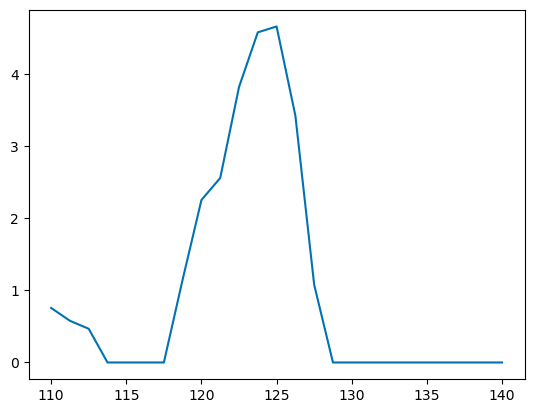

In [19]:
plt.plot(masses,sigs)